In [13]:
import numpy as np
import nlopt
import pandas as pd
from math import log, exp
from multiprocessing import Pool, cpu_count
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
def rho(rbp,g,L,d):
    r = rbp*(d+2*(g/rbp)*L*(1 - exp(-d/L)))
    return(r)

In [16]:
def single_dist_obj_fun(r,x):
    d,h0,h1,h2,th = x
    r = r*(d)
    calcH0 =(18+13*r + r**2 + 36*th + 22*th**2 + 4*th**3 + r*(6*th+th**2))/((1+th)*(18+13*r+r**2+54*th + 40*th**2+8*th**3+r*(r*th+19*th+6*th**2)))
    calcH2 = (th**2*(36+14*r+r**2+36*th+6*th*r+8*th**2))/((1+th)*(18+13*r+r**2+54*th + 40*th**2+8*th**3+r*(r*th+19*th+6*th**2)))
    calcH1 = 1 - calcH0 - calcH2
    
    val = h0*log(calcH0) + h1*log(calcH1)+h2*log(calcH2)
    return(val)

In [17]:
def single_dist_multi_ind_obj_fun(r,xl):
    res = [ single_dist_obj_fun(r,xs) for xs in xl]
    res = sum(res)
    return(res)

In [18]:
def find_max_like_single_dist(args):
    d, testChr = args
    opt = nlopt.opt(nlopt.LN_NELDERMEAD,1)
    opt.set_lower_bounds([0.0001])
    opt.set_upper_bounds([0.1])
    startPoint = [0.001]
    opt.set_max_objective(lambda x, grad: single_dist_obj_fun(x,testChr))
    res = opt.optimize(startPoint)
    return(res[0])

In [19]:
def calc_single_dist(x,rbp,g,L):
    d,h0,h1,h2,th = x
    
    r = rbp*(d+2*(g/rbp)*L*(1 - exp(-d/L)))
    
    calcH0 =(18+13*r + r**2 + 36*th + 22*th**2 + 4*th**3 + r*(6*th+th**2))/((1+th)*(18+13*r+r**2+54*th + 40*th**2+8*th**3+r*(r*th+19*th+6*th**2)))
    calcH2 = (th**2*(36+14*r+r**2+36*th+6*th*r+8*th**2))/((1+th)*(18+13*r+r**2+54*th + 40*th**2+8*th**3+r*(r*th+19*th+6*th**2)))
    calcH1 = 1 - calcH0 - calcH2
    
    val = h0*log(calcH0) + h1*log(calcH1)+h2*log(calcH2)
    return(val)

In [20]:
def single_chr_obj_fun(x_,arr):
    rbp, g, L = x_
    test = np.apply_along_axis(lambda x: calc_single_dist(x,rbp,g,L),1,arr)
    obfun = np.sum(test)
    #test = [calc_single_dist(x,rbp,g,L) for x in arr]
    #obfun = sum(test)
    return(obfun)

In [21]:
def across_chr_obj_fun(x,dfArrList,numChrs):
    
    rList = x[0:numChrs]
    gList = x[numChrs:numChrs+numChrs]
    L = x[-1]
    
    obFun = sum([single_chr_obj_fun([rs,gs,L],arr) for (rs,gs,arr) in list(zip(rList,gList,dfArrList))])
    
    return(obFun)

In [22]:
def find_max_like_single_ind(rep):
    
    numberChromsomes = 19
    dfListAuto = [ df.loc[(df['chromosome']== x) & (df['replicate']==rep) & (df['sample']==1) & (df['Unnamed: 0']<=10)] for x in list(range(1,numberChromsomes+1))]
    dfListAuto = [x.iloc[:,[0,4,5,6,11]].to_numpy() for x in dfListAuto]

    lowerBounds = [0.0001 for x in range(numberChromsomes)]+ [0.0001 for x in range(numberChromsomes)]+[10]
    upperBounds = [0.1 for x in range(numberChromsomes)]+[0.1 for x in range(numberChromsomes)]+[2000]
    startPoints = [0.001 for x in range(numberChromsomes)]+[0.001 for x in range(numberChromsomes)]+[50]


    opt=nlopt.opt(nlopt.LN_NELDERMEAD,numberChromsomes+numberChromsomes+1)

    opt.set_lower_bounds(lowerBounds)
    opt.set_upper_bounds(upperBounds)

    opt.set_max_objective(lambda x,grad: across_chr_obj_fun(x,dfListAuto,numberChromsomes))

    res = opt.optimize(startPoints)
    return(res)

In [23]:
def find_max_like_group_ind(rep):
    
    numberChromsomes = 19
    dfListAuto = [ df.loc[(df['chromosome']== x) & (df['replicate']==rep) & (df['Unnamed: 0']<=10)] for x in list(range(1,numberChromsomes+1))]
    dfListAuto = [combine_across_individuals(x) for x in dfListAuto]

    lowerBounds = [0.0001 for x in range(numberChromsomes)]+ [0.0001 for x in range(numberChromsomes)]+[10]
    upperBounds = [0.1 for x in range(numberChromsomes)]+[0.1 for x in range(numberChromsomes)]+[2000]
    startPoints = [0.001 for x in range(numberChromsomes)]+[0.001 for x in range(numberChromsomes)]+[50]


    opt=nlopt.opt(nlopt.LN_NELDERMEAD,numberChromsomes+numberChromsomes+1)

    opt.set_lower_bounds(lowerBounds)
    opt.set_upper_bounds(upperBounds)

    opt.set_max_objective(lambda x,grad: across_chr_obj_fun(x,dfListAuto,numberChromsomes))

    res = opt.optimize(startPoints)
    return(res)

In [24]:
def combine_across_individuals(thisDF):
    test = thisDF
    numSamples = len(test['name'].unique())
    test = test.groupby(['distances'],as_index=False).sum()
    test['H'] = test['H']/numSamples
    return(test.iloc[:,[0,1,2,3,7]].to_numpy())
    #return(test.iloc[:,[0,4,5,6,11]].to_numpy())
    #return( test.iloc[:,[0,4,5,6,11]].to_numpy() )

In [25]:
# requires correct path to the file of this name:
df = pd.read_csv('mathematicaInputMice_unbinned.tsv',delimiter='\t')

In [26]:
df

,name,chrom,distances,no_het_bins,one_het_bins,two_het_bins,H0Prop,H1Prop,H2Prop,H
0,H12,chr1,1,62864864,844714.0,13604,0.986531,0.013256,0.000213,0.006841
1,H12,chr1,2,62850711,854466.0,8706,0.986452,0.013411,0.000137,0.006842
2,H12,chr1,3,62840557,856190.0,7807,0.986437,0.013440,0.000123,0.006843
3,H12,chr1,4,62831402,855898.0,7907,0.986438,0.013437,0.000124,0.006843
4,H12,chr1,5,62821707,856675.0,7467,0.986431,0.013452,0.000117,0.006843
...,...,...,...,...,...,...,...,...,...,...
199995,H36,chrX,996,33330821,249597.0,673,0.992547,0.007433,0.000020,0.003736
199996,H36,chrX,997,33326448,249349.0,779,0.992551,0.007426,0.000023,0.003736
199997,H36,chrX,998,33321896,249468.0,706,0.992548,0.007431,0.000021,0.003736
199998,H36,chrX,999,33317379,249504.0,668,0.992547,0.007433,0.000020,0.003736


In [89]:
testChr = df.loc[(df['chrom']=='chr19')] 
testChr = combine_across_individuals(testChr)

In [90]:
jobs = [[x+1,testChr[x]] for x in list(range(0,1000))]
with Pool(cpu_count()) as p:
    thisResOneInd = p.map(find_max_like_single_dist,jobs)

In [91]:
print(thisResOneInd)

[0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0010887819867584198, 0.0001, 0.0001, 0.00155973094103756, 0.0026538457769876003, 0.0011221130371096822, 0.0027990249636920005, 0.0038369078874600283, 0.003517427823373873, 0.006068906080721581, 0.003928694152674871, 0.006490595998259685, 0.0037227996349727616, 0.0067891658030425775, 0.006891655352246016, 0.005508223867418835, 0.009390821677451274, 0.007954964327809736, 0.00779431953428211, 0.008728696441655302, 0.009310489463884731, 0.009388102722167967, 0.007821016392072486, 0.009621266938513146, 0.009930092625878748, 0.012318115233117714, 0.010285781860354018, 0.009416693353729078, 0.010977305126185272, 0.010412179565468976, 0.011615716791150494, 0.008806665039060042, 0.008308817005469333, 0.008287926673898983, 0.00841917029901524, 0.011396453285214828, 0.008484304264930416, 0.008769385337807488, 0.011373138668665066, 0.01016066131654661, 0.010332357025144026, 0.00904190

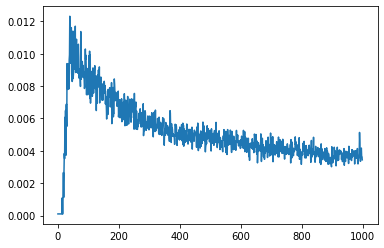

In [92]:
plt.plot(thisResOneInd)
plt.show()